In [323]:
import pandas as pd
import eikon as ek
import matplotlib.pyplot as plt

ek.set_app_key('APP_KEY')
from matplotlib.pyplot import figure



Following function runs through all the months in  a given range of years and uses previous month's returns as weightage fractions for current month's investments. Only top 10 performing stocks out of a universe of Top 100 Indian stocks by mkt cap are picked each month.

In [ ]:
dates = []
returns_list = []

for YEAR in range(2011,2015):
    for MONTH in range(1,13):
        date = str(YEAR) + (str(0) + str(MONTH) if MONTH < 10 else str(MONTH)) + str(calendar.monthrange(YEAR,MONTH)[1])
        dates.append(date)

for i in range(len(dates)):
    print(dates[i])
    start_date = dates[i]
    end_date = dates[i]
    
    nif100 = ek.get_data('0#.NIFTY100('+start_date + str(')'),['TR.RIC'])

    if(i == 0):
        curr_month = ek.get_data(nif100[0]['Instrument'].str.split('^',expand=True)[0].tolist(),['TR.TotalReturn1Mo.date','TR.TotalReturn1Mo'], {"SDate":start_date, "EDate":end_date})[0]

    weights = curr_month[curr_month['1 Month Total Return'] > 0].dropna(axis=0).sort_values(by='1 Month Total Return')[-10:]
    weights['weights'] = weights['1 Month Total Return']/weights['1 Month Total Return'].sum()
    
    if(i < len(dates)-1):
        start_date = dates[i+1]
        end_date = dates[i+1]
    else:
        break
    next_month = ek.get_data(nif100[0]['Instrument'].str.split('^',expand=True)[0].tolist(),['TR.TotalReturn1Mo.date','TR.TotalReturn1Mo'], {"SDate":start_date, "EDate":end_date})[0]

    portfolio = pd.concat([weights[['Instrument','weights']],next_month],axis=1,names=['Instrument'],join='inner')

    returns = ((1+(portfolio['1 Month Total Return']/100))*portfolio['weights']).sum()
    
    returns_list.append(returns)    
    curr_month = next_month

        
print(returns_list)

All the returns are combined in a list and we create a pandas dataframe out of it to find the cumulative returns

In [256]:
PnL = pd.DataFrame({'Date':dates[:-1],'Rets':returns_list})
PnL.loc[len(PnL)] = [dates[-1],1]
PnL['Rets'] = PnL['Rets'].shift(1).fillna(1)
PnL['CumRts'] = PnL['Rets'].cumprod()




Getting benchmark data. In this experiment the benchmark is Indian NIFTY 50 stock index

In [264]:
year = PnL['Date'][0][:4]
mnth = PnL['Date'][0][4:6]
day= PnL['Date'][0][6:]
stt_date = str(year + "-" + mnth + "-" + day )
year = PnL['Date'][len(PnL)-1][:4]
mnth = PnL['Date'][len(PnL)-1][4:6]
day= PnL['Date'][len(PnL)-1][6:]
end_date = str(year + "-" + mnth + "-" + day )

Benchmark = ek.get_timeseries(rics=['.NSEI'],fields=['CLOSE'],
                            start_date=stt_date,
                            end_date='2020-10-31',
                            interval='daily',corax='adjusted')

Benchmark = Benchmark.resample('M').last()
Benchmark_Returns = Benchmark.pct_change()
Benchmark_Returns.iloc[0]['CLOSE'] = 0

/Users/vipultanwar/Documents/kite/kite/lib/python3.8/site-packages/eikon/time_series.py:282: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  datapoints = pd.np.array(timeseries['dataPoints'])
/Users/vipultanwar/Documents/kite/kite/lib/python3.8/site-packages/eikon/time_series.py:284: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  timestamps = pd.np.array([tz_replacer(value) for value in datapoints[:, timestamp_index]],
/Users/vipultanwar/Documents/kite/kite/lib/python3.8/site-packages/eikon/time_series.py:286: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  datapoints = pd.np.delete(datapoints, pd.np.s_[timestamp_index],
/Users/vipultanwar/Documents/kite/kite/lib/python3.8/site-packages/eikon/time_series.py:209: FutureWarning: T

Sample comparison for some years (Aplogies for bad formatting of chart)

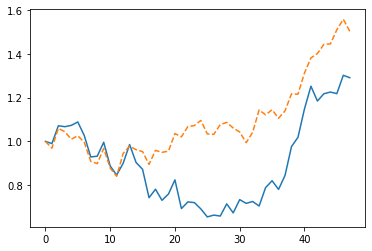

In [259]:

plt.plot(PnL['CumRts'])
plt.plot((((Benchmark_Returns['CLOSE']+1).cumprod()).reset_index())['CLOSE'],'--')
plt.show()

## Analysis ## 

Attached is the CSV file containing monthly returns from the aforementioned Momentum strategy. We want to see how it performed during various cycles fo interst rates. For comparison we are taking Indina 10 Y Gov Bond yield as rates indicator and looking at the relative performance with NIFTY50

In [343]:
Momentum_strategy_returns = pd.read_csv('2011_2020.csv')[['Date','Rets']]


In [ ]:
_10YT = ek.get_timeseries(rics=['IN10YT=RR'],fields=['CLOSE'],
                            start_date=stt_date,
                            end_date='2020-11-30',
                            interval='monthly',corax='adjusted')

In [353]:
Momentum_strategy_returns.index = _10YT.index

## Final Plot ##

On the left vertical axis is the portfolio value for 1 as starting value from 2011 to 2020. Right vertical axis indiates the yield on a 10Y Indian gov bond. X axis shows year. 

For perspective on interest rates, we've used 2 years rolling mean of bond yield

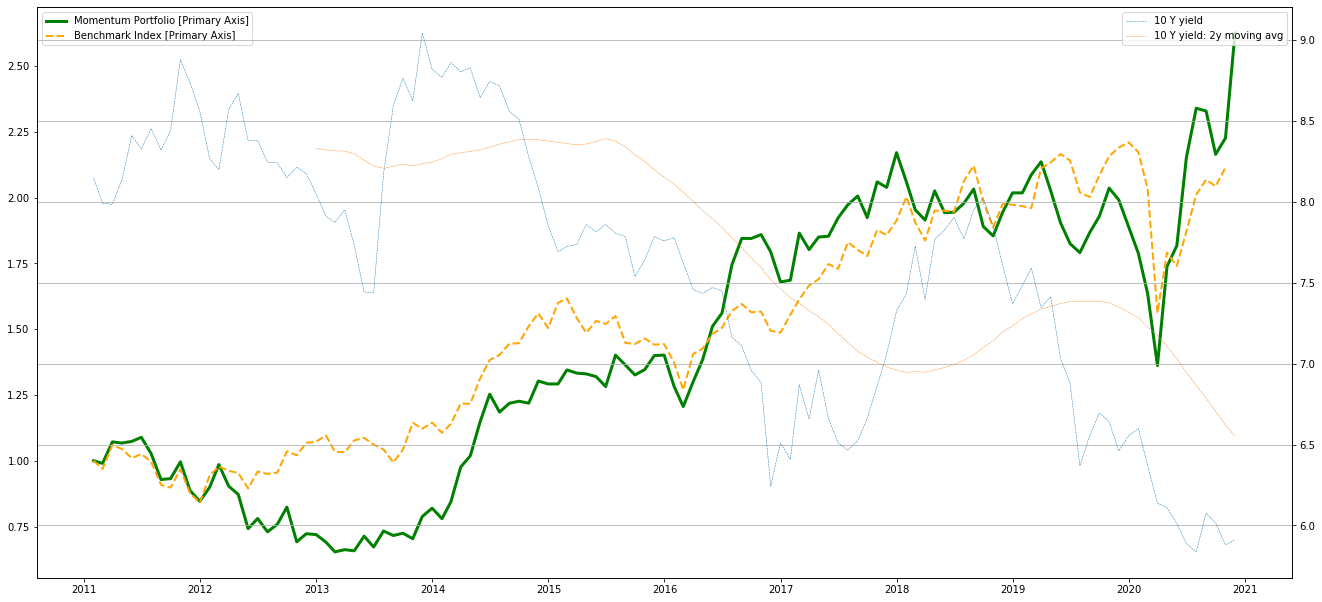

In [371]:
fig, ax = plt.subplots()
# figure(num=None, figsize=(18, 6), facecolor='w', edgecolor='k')
fig.set_size_inches(22.5, 10.5)

ax2 = ax.twinx()
ax.plot(Momentum_strategy_returns['Rets'].cumprod(),label='Momentum Portfolio [Primary Axis]',color='green',linewidth=3)
ax.plot((((Benchmark_Returns['CLOSE']+1).cumprod())),'--',label = 'Benchmark Index [Primary Axis]',color='orange',linewidth=2)
ax2.plot(_10YT['CLOSE'],'--',label = '10 Y yield',linewidth=0.5)
ax2.plot(_10YT['CLOSE'].rolling(24).mean(),'--',label = '10 Y yield: 2y moving avg',linewidth=0.5)

ax.legend()
ax2.legend()
plt.grid()
plt.show()

In [360]:
plt.savefig('plot.png')

<Figure size 432x288 with 0 Axes>